In [2]:
import nmresearch as nmr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import os
import pickle

In [3]:
# decent color schemes for plots and such

colors = [
    "#1984c5",
    "#22a7f0",
    "#63bff0",
    "#a7d5ed",
    "#e2e2e2",
    "#e1a692",
    "#de6e56",
    "#e14b31",
    "#c23728",
]

colors_single = [
    "#fff5eb",
    "#fee6ce",
    "#fdd0a2",
    "#fdae6b",
    "#fd8d3c",
    "#f16913",
    "#d94801",
    "#a63603",
    "#7f2704",
]
colors_single.reverse()
zcorr_str = r"$\langle$ $\hat{S}_z (nT)$ $\hat{S}_z$ $\rangle$"
xcorr_str = r"$\langle$ $\hat{S}_x (nT)$ $\hat{S}_x$ $\rangle$"
mucorr_str = r"$\langle$ $\hat{S}_\mu (nT)$ $\hat{S}_\mu$ $\rangle$"
zcorr_loc_str = r"$\langle$ $\hat{S}_z^{(0)} (nT)$ $\hat{S}_z^{(0)}$ $\rangle$"

In [4]:
plt.rcParams.update({"font.size": 14})
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

In [5]:
a=4.0232/2

N=1
s=1
m=1
A=1
J=N*m
MHz = 1e6
kHz = 1e3
us = 1e-6
T = N/(A*m)
mu0 = 4*np.pi*1e-7 * (N/A**2)
hbar = 1.054571817 * 1e-34 * (J*s)
gammaF = 2*np.pi * 40.078 * (MHz/T) # spin 1/2
gammaE = 2*np.pi * 28024.9514242 * (MHz/T) # spin 1/2 
gammaLi = 2*np.pi * 16.546 * (MHz/T) # spin 3/2

# coupling strengths in Hz * A**3
Jf = (hbar/(2*np.pi)) * (mu0/ (4*np.pi)) * gammaF**2 * (10**10)**3
Jlif = (hbar/(2*np.pi)) * (mu0/ (4*np.pi)) * gammaLi*gammaF * (10**10)**3

In [6]:
def get_tpc_data(filename, expt_no, folder="expt9", normalize=True, use_real=False):
    filename = "data/" + filename
    try:
        data = pickle.load(open(filename, "rb"))
    except FileNotFoundError:
        data = nmr.Experiment(expt_no, folder=folder).load_tpc(
            use_real=use_real, normalize=normalize
        )
        with open(filename, "wb") as f:
            pickle.dump(data, f)
    return data


def get_tpc3d_data(filename, expt_no, folder="expt9", normalize=False):
    filename = "data/" + filename
    try:
        data = pickle.load(open(filename, "rb"))
    except FileNotFoundError:
        data = nmr.Experiment(expt_no, folder=folder).load_tpc3d(
            use_real=False, normalize=normalize
        )
        with open(filename, "wb") as f:
            pickle.dump(data, f)
    return data

In [7]:
24 * 4 * 2

192

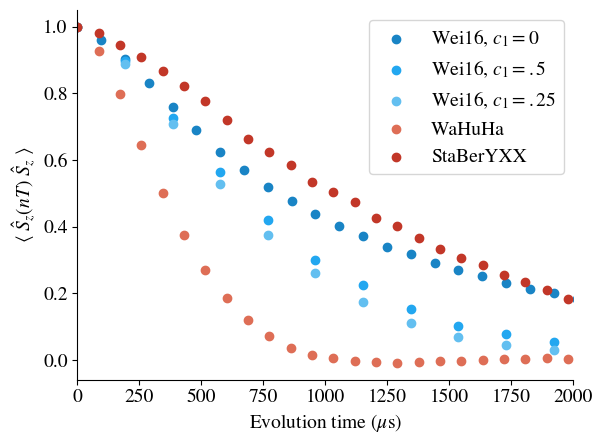

In [8]:
# Test the performance of the disorder generators vai their suspension performance
# e.g. seq_susp = seq + pi + seq + pi, except wei16, which can be tuned to suspension
# with the c1 knob

staber_pi = get_tpc_data("staber_pi.dat", 344)
whh_pi = get_tpc_data("whh_pi.dat", 282)
staberYXX_zz = get_tpc_data("staberYXX_zz.dat", 380)
staberYXX_xx = get_tpc_data("staberYXX_xx.dat", 382)
ken_suspension = get_tpc_data("ken_suspension.dat", 279)
ken_50_pi = get_tpc_data("ken_50_pi.dat", 582)
ken_25_pi = get_tpc_data("ken_25_pi.dat", 583)
t_list = np.arange(0, 25, 1) * 96


plt.scatter(t_list, ken_suspension, label=r"Wei16, $c_1=0$", color=colors[0])
plt.scatter(t_list * 2, ken_50_pi, label=r"Wei16, $c_1=.5$", color=colors[1])
plt.scatter(t_list * 2, ken_25_pi, label=r"Wei16, $c_1=.25$", color=colors[2])
plt.scatter(t_list * (43 * 2 / 96), whh_pi, label="WaHuHa", color=colors[6])
plt.scatter(
    t_list * (43 * 2 / 96), staberYXX_zz[:25], label="StaBerYXX", color=colors[-1]
)

plt.legend()
plt.xlabel(r"Evolution time ($\mu$s)")
plt.xlim([0, 2000])
plt.ylabel(zcorr_str)
# plt.title("Suspension Performance of Disorder Generators")
plt.savefig("supension_performance.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("suspension_performance.png", format="png", dpi=900, bbox_inches="tight")
plt.show()

In [9]:
def find_one_over_e_time(data, times):
    one_over_e_times = {}
    for label, series in data.items():
        initial_value = series[0]
        one_over_e_value = initial_value / np.e
        one_over_e_time = None
        for t, value in zip(times, series):
            if value <= one_over_e_value:
                one_over_e_time = t
                break
        one_over_e_times[label] = one_over_e_time
    return one_over_e_times


# Find 1/e times for the plotted curves
one_over_e_times_ken_suspension = find_one_over_e_time(
    {"ken_suspension": ken_suspension}, t_list
)
one_over_e_times_ken_50_pi = find_one_over_e_time({"ken_50_pi": ken_50_pi}, t_list * 2)
one_over_e_times_whh_pi = find_one_over_e_time(
    {"whh_pi": whh_pi}, t_list * (43 * 2 / 96)
)
one_over_e_times_staberYXX_zz = find_one_over_e_time(
    {"staberYXX_zz": staberYXX_zz[:25]}, t_list * (43 * 2 / 96)
)

# Combine all results
one_over_e_times = {
    **one_over_e_times_ken_suspension,
    **one_over_e_times_ken_50_pi,
    **one_over_e_times_whh_pi,
    **one_over_e_times_staberYXX_zz,
}

print("1/e times for each curve:")
for label, time in one_over_e_times.items():
    print(f"{label}: {time} µs")

1/e times for each curve:
ken_suspension: 1248 µs
ken_50_pi: 960 µs
whh_pi: 516.0 µs
staberYXX_zz: 1376.0 µs


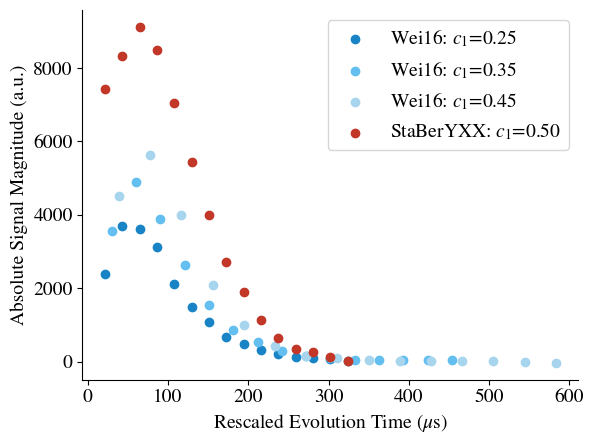

In [10]:
# Test the measurable signal for the disordered state preparation technique
wei16_25 = get_tpc_data("wei16_25.dat", 317, normalize=False)
wei16_35 = get_tpc_data("wei16_35.dat", 318, normalize=False)
wei16_45 = get_tpc_data("wei16_45.dat", 319, normalize=False)
# staber_100 = get_tpc_data("staber_100.dat", 346, normalize=False)
staberYXX_50 = get_tpc_data("staberYXX_50.dat", 353, normalize=False)

tau = 3.6
T = 24 * tau
times = np.arange(1, 16, 1) * T
plt.scatter(0.25 * times, wei16_25, label=r"Wei16: $c_1$=0.25", color=colors[0])
plt.scatter(0.35 * times, wei16_35, label=r"Wei16: $c_1$=0.35", color=colors[2])
plt.scatter(0.45 * times, wei16_45, label=r"Wei16: $c_1$=0.45", color=colors[3])
# plt.scatter(times / 2, staber_100, label=r"Staber: $c_1$=1.00", color=colors[5])
plt.scatter(
    0.5 * times / 2, staberYXX_50, label=r"StaBerYXX: $c_1$=0.50", color=colors[8]
)
plt.legend()
plt.xlabel(r"Rescaled Evolution Time ($\mu$s)")
plt.ylabel("Absolute Signal Magnitude (a.u.)")
plt.savefig("disorder_prep.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("disorder_prep.png", format="png", dpi=900, bbox_inches="tight")
plt.show()

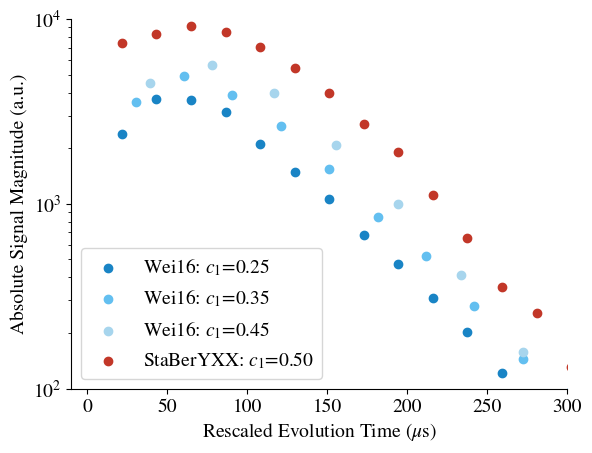

In [11]:


plt.scatter(0.25 * times, wei16_25, label=r"Wei16: $c_1$=0.25", color=colors[0])
plt.scatter(0.35 * times, wei16_35, label=r"Wei16: $c_1$=0.35", color=colors[2])
plt.scatter(0.45 * times, wei16_45, label=r"Wei16: $c_1$=0.45", color=colors[3])
# ax.scatter(times / 2, staber_100, label=r"Staber: $c_1$=1.00", color=colors[5])
plt.scatter(
    0.5 * times / 2, staberYXX_50, label=r"StaBerYXX: $c_1$=0.50", color=colors[8]
)
plt.legend()
plt.xlim(-10, 300)
plt.ylim(1e2, 1e4)
plt.xlabel(r"Rescaled Evolution Time ($\mu$s)")
plt.ylabel("Absolute Signal Magnitude (a.u.)")
plt.yscale("log")
plt.savefig("disorder_prep_log.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("disorder_prep_log.png", format="png", dpi=900, bbox_inches="tight")
plt.show()

In [12]:
T = 24*4

def slope_fit(data, start, end, t_list):
    if end > 35:
        return 0
    x = np.log(t_list[start: end])
    X = sm.add_constant(x)
    y = -np.log(data[start:end].flatten())
    ols = sm.OLS(y, X)
    ols_result = ols.fit()
    slopes = ols_result.params[1]
    intercept = ols_result.params[0]
    err = ols_result.conf_int()[1, 1] - ols_result.params[1]
    return slopes,intercept,err

slopes_fit = {}
slopes_err = {}
intercept_fit = {} 

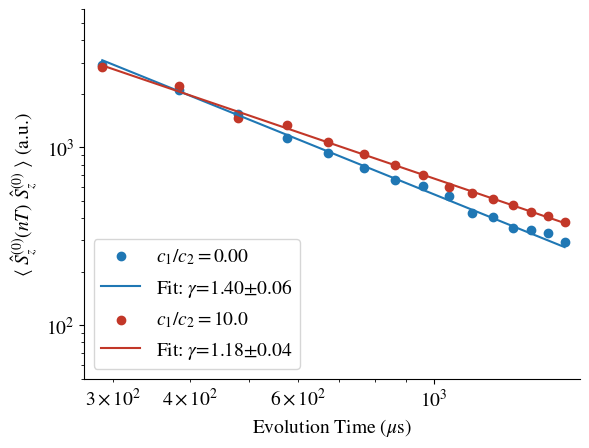

In [49]:
times = np.arange(3*T, 18*T,T)

plt.xscale("log")
plt.yscale("log")

data = get_tpc_data("c1_0_c2_01.dat", 721, normalize=False,use_real=True)
m,b,err = slope_fit(data,1,12,times)
slopes_fit[(0.0, .01)] = m
slopes_err[(0.0, .01)] = err
intercept_fit[(0.0, .01)] = b
plt.scatter(times,data,label=rf"$c_1/c_2 = 0.00$",marker="o")
plt.plot(times, np.exp(-m*np.log(times)-b), label=rf"Fit: $\gamma$={m:.2f}"+ r"$\pm$" + f"{err:.2f}")

data = get_tpc_data("c1_10_c2_01.dat", 730, normalize=False,use_real=True)
m,b,err = slope_fit(data,0,15,times)
slopes_fit[(0.10, .01)] = m
slopes_err[(0.10, .01)] = err
intercept_fit[(0.10, .01)] = b
plt.scatter(times,data,label=rf"$c_1/c_2 = 10.0$",marker="o",color=colors[-1])
plt.plot(times, np.exp(-m*np.log(times)-b), label=rf"Fit: $\gamma$={m:.2f}"+ r"$\pm$" + f"{err:.2f}",color=colors[-1])



plt.legend(loc="lower left")
plt.xlim(2.8*T, 18*T)
plt.ylim(5e1,6e3)
plt.xlabel(r"Evolution Time ($\mu$s)")
plt.ylabel(zcorr_loc_str + " (a.u.)")

plt.savefig("diffusion_v_slow.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("diffusion_v_slow.png", format="png", dpi=900, bbox_inches="tight")

plt.show()


In [14]:
c1, c2 = .05, .01
start, end = 1, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 695, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .01, .01
start, end = 2, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 684, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .06, .01
start, end = 2, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 701, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .07, .01
start, end = 2, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 703, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .08, .01
start, end = 2, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 711, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .00, .01
start, end = 1, 12
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 721, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .09, .01
start, end = 0, 12
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 728, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .11, .01
start, end = 0, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 734, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .12, .01
start, end = 0, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 735, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .15, .01
start, end = 0, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 740, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .2, .01
start, end = 0, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 741, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .02, .01
start, end = 1, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 746, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .03, .01
start, end = 4, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 752, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .04, .01
start, end = 2, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 753, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

In [15]:
c1, c2 = .00, .02
start, end = 1, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 762, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .14, .02
start, end = 1, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 769, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .01, .02
start, end = 1, 13
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 806, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .04, .02
start, end = 1, 12
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 811, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .08, .02
start, end = 4, 11
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 816, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .09, .02
start, end = 1, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 822, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .10, .02
start, end = 3, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 823, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .12, .02
start, end = 2, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 831, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .15, .02
start, end = 2, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 837, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

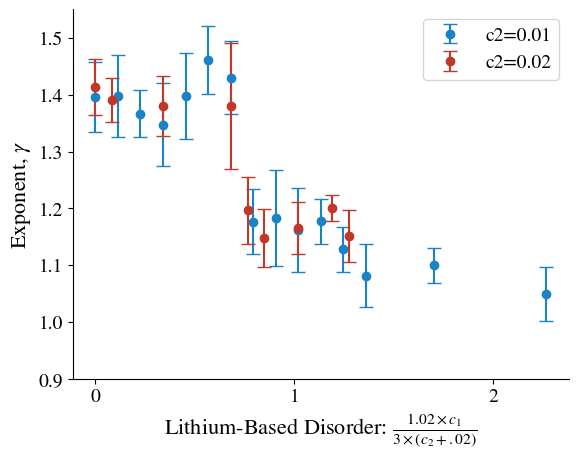

In [47]:
# Organize
unique_c2_values = sorted(set(key[1] for key in slopes_fit.keys()))
slopes_by_c2 = {c2: [] for c2 in unique_c2_values}
errors_by_c2 = {c2: [] for c2 in unique_c2_values}
disorder_by_c2 = {c2: [] for c2 in unique_c2_values}


for key, slope in slopes_fit.items():
    c1, c2 = key
    disorder_strength = 1.02*(1/3)*(c1)/(c2+.02)
    slopes_by_c2[c2].append(slope)
    errors_by_c2[c2].append(slopes_err[key])
    disorder_by_c2[c2].append(disorder_strength)
    
#plotting
disorder = np.arange(0, 8, 0.1)

plt.errorbar(disorder_by_c2[0.01], slopes_by_c2[0.01], yerr=errors_by_c2[0.01], fmt='o', capsize=5, label="c2=0.01", color=colors[0])
plt.errorbar(disorder_by_c2[0.02], slopes_by_c2[0.02], yerr=errors_by_c2[0.02], fmt='o', capsize=5, label="c2=0.02", color=colors[-1])
plt.xlabel(r"Lithium-Based Disorder: $\frac{1.02 \times c_1}{3\times(c_2+.02)}$", fontsize=16)
plt.ylabel(r"Exponent, $\gamma$", fontsize=16)
#plt.title(r"Power Law Fits, $S(t) \sim t^{-\gamma}$", fontsize=16)
plt.ylim(.9, 1.55)
#plt.plot(disorder, 0.14 * (1 - np.tanh(3.5 * (disorder - 2.6))) + 1.12, label="Tanh Overlay", linestyle='--', color='black')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))


plt.savefig("power_law_li.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("power_law_li.png", format="png", dpi=900, bbox_inches="tight")

plt.show()

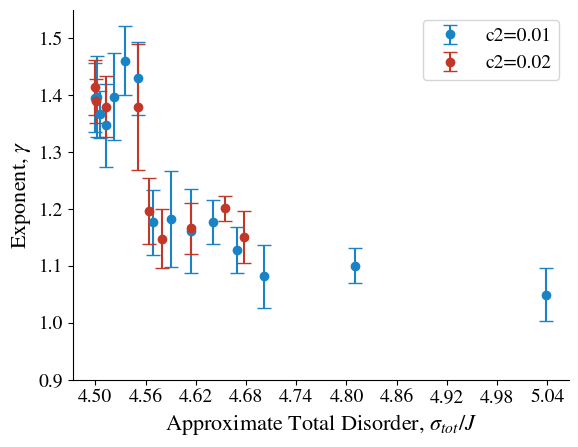

In [48]:
# Organize
unique_c2_values = sorted(set(key[1] for key in slopes_fit.keys()))
slopes_by_c2 = {c2: [] for c2 in unique_c2_values}
errors_by_c2 = {c2: [] for c2 in unique_c2_values}
disorder_by_c2 = {c2: [] for c2 in unique_c2_values}


for key, slope in slopes_fit.items():
    c1, c2 = key
    li_disorder = (1.02)*(1/3)*c1/(c2+.02) 
    disorder_strength = np.sqrt(li_disorder**2 + 4.5**2)
    slopes_by_c2[c2].append(slope)
    errors_by_c2[c2].append(slopes_err[key])
    disorder_by_c2[c2].append(disorder_strength)
    
#plotting
disorder = np.arange(0, 8, 0.1)

plt.errorbar(disorder_by_c2[0.01], slopes_by_c2[0.01], yerr=errors_by_c2[0.01], fmt='o', capsize=5, label="c2=0.01", color=colors[0])
plt.errorbar(disorder_by_c2[0.02], slopes_by_c2[0.02], yerr=errors_by_c2[0.02], fmt='o', capsize=5, label="c2=0.02", color=colors[-1])
plt.xlabel(r"Approximate Total Disorder, $\sigma_{tot}/J$", fontsize=16)
plt.ylabel(r"Exponent, $\gamma$", fontsize=16)
#plt.title(r"Power Law Fits, $S(t) \sim t^{-\gamma}$", fontsize=16)
plt.ylim(.9, 1.55)
#plt.plot(disorder, 0.14 * (1 - np.tanh(3.5 * (disorder - 2.6))) + 1.12, label="Tanh Overlay", linestyle='--', color='black')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))


plt.savefig("power_law_inter_offset.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("power_law_inter_offset.png", format="png", dpi=900, bbox_inches="tight")

plt.show()

C:\Users\awsta\AppData\Local\Temp\ipykernel_13924\4012138016.py:9: RuntimeWarning: invalid value encountered in sqrt
  D = np.where(disorder_param <= 1, (.5/(disorder_param+.5))*np.sqrt(1-disorder_param**2 ), 0)


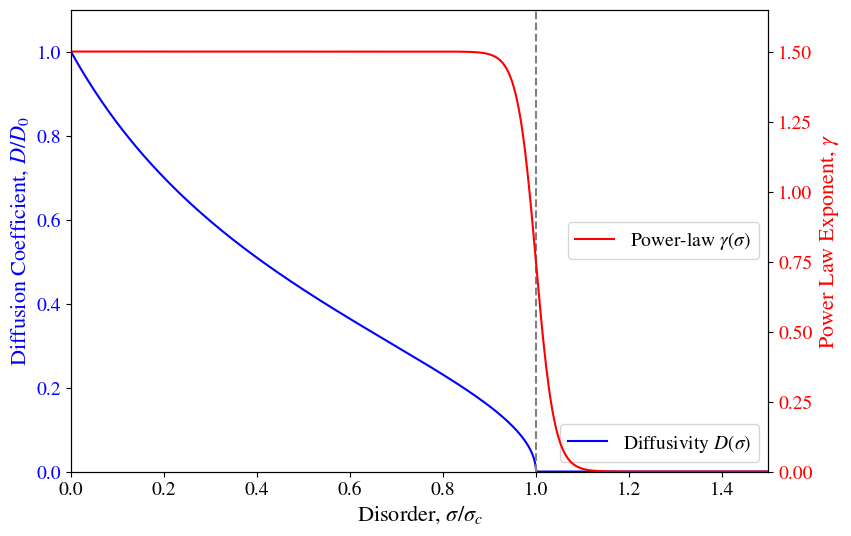

In [46]:
plt.rcParams["axes.spines.right"] = True
plt.rcParams["axes.spines.top"] = True
fig, ax1 = plt.subplots(figsize=(9, 6))

# Define the disorder parameter range
disorder_param = np.linspace(0, 1.5, 500)

# Diffusion coefficient, D
D = np.where(disorder_param <= 1, (.5/(disorder_param+.5))*np.sqrt(1-disorder_param**2 ), 0)

# Power law exponent, γ
gamma = 0.75 * (1 - np.tanh(25 * (disorder_param - 1)))

# Power law exponent, γ
gamma_obs = .75*(1 - .3*np.tanh(25 * (disorder_param - 1))) + .5

# Plot diffusion coefficient
ax1.plot(disorder_param, D, label=r"Diffusivity $D(\sigma)$", color="blue")
ax1.set_xlabel(r"Disorder, $\sigma/\sigma_c$", fontsize=16)
ax1.set_ylabel(r"Diffusion Coefficient, $D/D_0$", color="blue", fontsize=16)
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_ylim(0, 1.1)

# Create a second y-axis for the power law exponent
ax2 = ax1.twinx()
ax2.plot(disorder_param, gamma, color="red", label=r"Power-law $\gamma(\sigma)$")
#ax2.plot(disorder_param, gamma_obs, color="red", linestyle="--", label=r"Observed    $\gamma(\sigma)$")
ax2.set_ylabel(r"Power Law Exponent, $\gamma$", color="red", fontsize=16)
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0, 1.65)
plt.xlim(0,1.5)

ax2.yaxis.set_major_locator(plt.MultipleLocator(0.25))
ax1.axvline(x=1, color="gray", linestyle="--")


ax2.legend(loc="center right")
ax1.legend(loc="lower right")


plt.savefig("theory_picture.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("theory_picture.png", format="png", dpi=900, bbox_inches="tight")

plt.show()

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

C:\Users\awsta\AppData\Local\Temp\ipykernel_13924\1582911381.py:8: RuntimeWarning: invalid value encountered in sqrt
  D = np.where(disorder_param <= 1, (.5/(disorder_param+.5))*np.sqrt(1-disorder_param**2 ), 0)


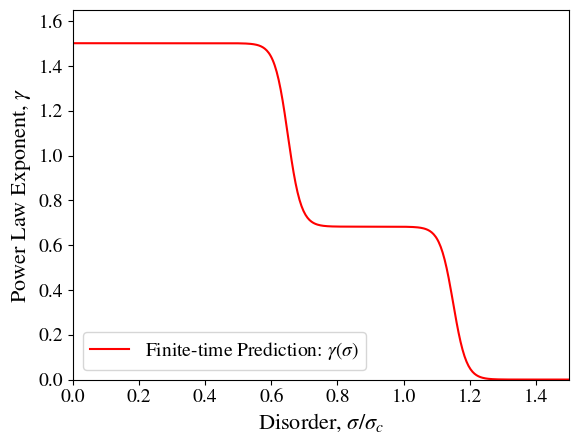

In [39]:
plt.rcParams["axes.spines.right"] = True
plt.rcParams["axes.spines.top"] = True

# Define the disorder parameter range
disorder_param = np.linspace(0, 1.5, 500)

# Diffusion coefficient, D
D = np.where(disorder_param <= 1, (.5/(disorder_param+.5))*np.sqrt(1-disorder_param**2 ), 0)

# Power law exponent, γ
gamma = 1.365*0.5* (.6*(1 - np.tanh(25 * (disorder_param - .65)))+.5*(1 - np.tanh(25 * (disorder_param - 1.15))))


# Create a second y-axis for the power law exponent
plt.plot(disorder_param, gamma, color="red", label=r"Finite-time Prediction: $\gamma(\sigma)$")
#ax2.plot(disorder_param, gamma_obs, color="red", linestyle="--", label=r"Observed    $\gamma(\sigma)$")
plt.ylabel(r"Power Law Exponent, $\gamma$", fontsize=16)
plt.ylim(0, 1.65)
plt.xlim(0,1.5)
plt.xlabel(r"Disorder, $\sigma/\sigma_c$", fontsize=16)

plt.legend(loc="lower left")

plt.savefig("theory_picture_finite.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("theory_picture_finite.png", format="png", dpi=900, bbox_inches="tight")

plt.show()


plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False


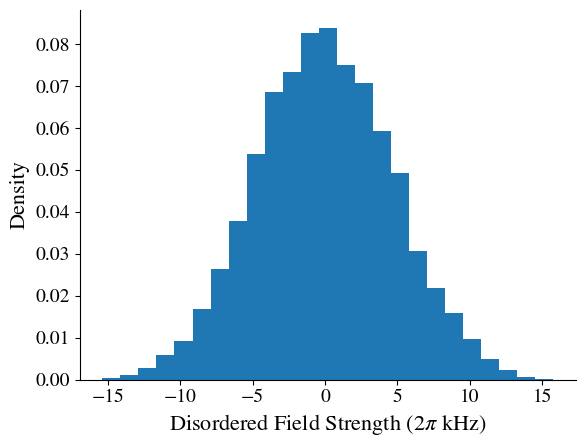

In [20]:
filename = "data/li_disorder_distro.dat"
with open(filename, "rb") as f:
    distro111 = pickle.load(f)
        
plt.hist(
    np.array(distro111)/1000,
    bins=25,
    density=True,
    label="Monte-Carlo \n Simulation",
)
plt.xlabel(r"Disordered Field Strength ($2\pi$ kHz)", fontsize=16)
plt.ylabel("Density", fontsize=16)

plt.savefig("disorder_distro.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("disorder_distro.png", format="png", dpi=900, bbox_inches="tight")

plt.show()


In [21]:
try:
    times = np.array([5, 50, 65, 70, 75, 100, 200, 300, 400])*us
    para_sin_distros = pickle.load(open("data/para_sin_distros.dat", "rb"))
    perp_sin_distros = pickle.load(open("data/perp_sin_distros.dat", "rb"))
    horiz_sin_distros = pickle.load(open("data/horiz_sin_distros.dat", "rb"))
except FileNotFoundError:
    print("trouble in paradise :(")
    
rf=5
k_vals = np.arange(-rf,rf+1,1)
para = [(2*k*a,2*k*a,2*k*a) for k in k_vals]
perp = [(k*a,-k*a,0) for k in k_vals]
horiz = [(k*a,0,0) for k in k_vals]

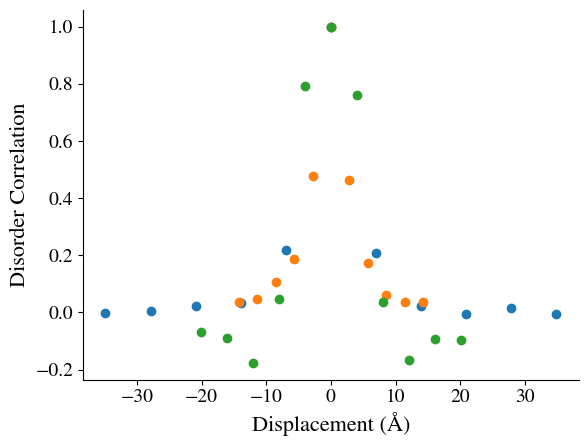

In [22]:
time = 5*us

para_d = np.sqrt(12)*k_vals*a
para_means=np.mean(para_sin_distros[time], axis=1)

perp_d = np.sqrt(2)*k_vals*a
perp_means=np.mean(perp_sin_distros[time], axis=1)

horiz_d = 2*k_vals*a
horiz_means=np.mean(horiz_sin_distros[time],axis=1)

plt.scatter(para_d,para_means/np.max(para_means))
plt.scatter(perp_d,perp_means/np.max(perp_means))
plt.scatter(horiz_d,horiz_means/np.max(horiz_means))

plt.xlabel(r"Displacement (Å)", fontsize=16)
plt.ylabel(r"Disorder Correlation", fontsize=16)


plt.savefig("sin_disorder_5.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("sin_disorder_5.png", format="png", dpi=900, bbox_inches="tight")

plt.show()

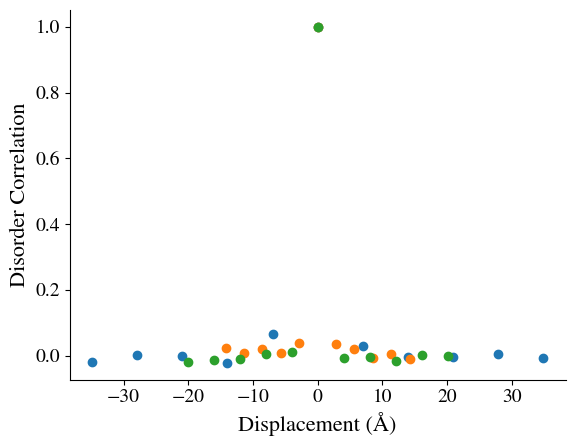

In [23]:
time = 75*us

para_d = np.sqrt(12)*k_vals*a
para_means=np.mean(para_sin_distros[time], axis=1)

perp_d = np.sqrt(2)*k_vals*a
perp_means=np.mean(perp_sin_distros[time], axis=1)

horiz_d = 2*k_vals*a
horiz_means=np.mean(horiz_sin_distros[time],axis=1)

plt.scatter(para_d,para_means/np.max(para_means))
plt.scatter(perp_d,perp_means/np.max(perp_means))
plt.scatter(horiz_d,horiz_means/np.max(horiz_means))

plt.xlabel(r"Displacement (Å)", fontsize=16)
plt.ylabel(r"Disorder Correlation", fontsize=16)

plt.savefig("sin_disorder_75.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("sin_disorder_75.png", format="png", dpi=900, bbox_inches="tight")

plt.show()

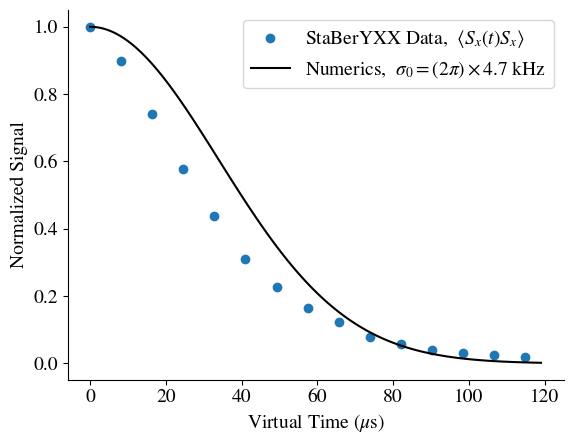

In [24]:
data = get_tpc_data(f"staber_disorder_XX.dat", 912, normalize=True,use_real=True)

T=4.1*12
times = np.arange(0*T, 15*T,T)
plt.scatter(times/6,data,label=rf"StaBerYXX Data,  $\left\langle S_x(t)S_x\right\rangle$")

tsmooth = np.arange(0,120, 1)
h = (2*np.pi) * 4.7 * 10**-3 # Value from numerics
plt.plot(tsmooth,np.exp(-0.5*(h*(tsmooth))**2),label=r"Numerics,  $\sigma_0=(2\pi)\times4.7$ kHz",color="black")

plt.xlabel(rf"Virtual Time ($\mu$s)")
plt.ylabel(r"Normalized Signal")
plt.legend()


plt.savefig("staber_gaussian.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("staber_gaussian.png", format="png", dpi=900, bbox_inches="tight")

plt.show()

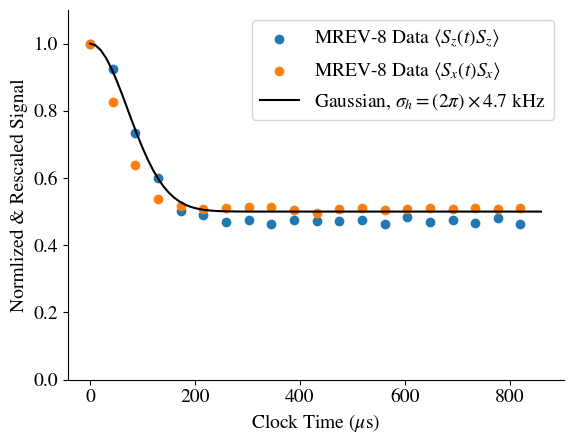

In [25]:
dataxx = get_tpc_data(f"mrev_xx.dat", 219, normalize=True,use_real=False)
datazz = get_tpc_data(f"mrev_zz.dat", 220, normalize=True,use_real=False)

tau = 3.6
cycle = 12*tau
t_list = np.array([i*cycle for i in range(len(dataxx))])

start = 6
end = 20
x = t_list[start:end]
y = -np.log(dataxx[start:end])
px = np.polyfit(x,y, 1)


x = t_list[start:end]
y = -np.log(datazz[start:end])
pz = np.polyfit(x,y, 1)

plt.scatter(t_list,datazz/np.exp(-t_list*pz[0]),label=r"MREV-8 Data $\langle S_z(t)S_z \rangle$")
plt.scatter(t_list,dataxx/np.exp(-t_list*px[0]),label=r"MREV-8 Data $\langle S_x(t)S_x \rangle$")
plt.ylim([0,1.1])

tsmooth = np.arange(0,43.2*len(datazz), 10)
h = (2*np.pi) * 4.7 * 10**-3 # Value from numerics
plt.plot(tsmooth,1/2+1/2*np.exp(-((h)*tsmooth/3)**2),label=r"Gaussian, $\sigma_h=(2\pi)\times4.7$ kHz",color="black")

plt.legend()
plt.xlabel(r"Clock Time ($\mu$s)")
plt.ylabel("Normlized & Rescaled Signal")
plt.savefig("mrev_gaussian.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("mrev_gaussian.png", format="png", dpi=900, bbox_inches="tight")
plt.show()

In [26]:
T=24*4
times = np.arange(0*T, 15*T,T)

fids= {}
fids[(0.0,0.01)] = get_tpc_data(f"fid_01.dat", 858, normalize=False,use_real=True)
fids[(0.0,0.02)] = get_tpc_data(f"fid_02.dat", 863, normalize=False,use_real=True)
fids[(0.0,0.03)] = get_tpc_data(f"fid_03.dat", 865, normalize=False,use_real=True)
fids[(0.0,0.00)] = get_tpc_data(f"fid_00.dat", 870, normalize=False,use_real=True)
fids[(0.0,0.04)] = get_tpc_data(f"fid_04.dat", 871, normalize=False,use_real=True)
fids[(0.0,0.05)] = get_tpc_data(f"fid_05.dat", 872, normalize=False,use_real=True)

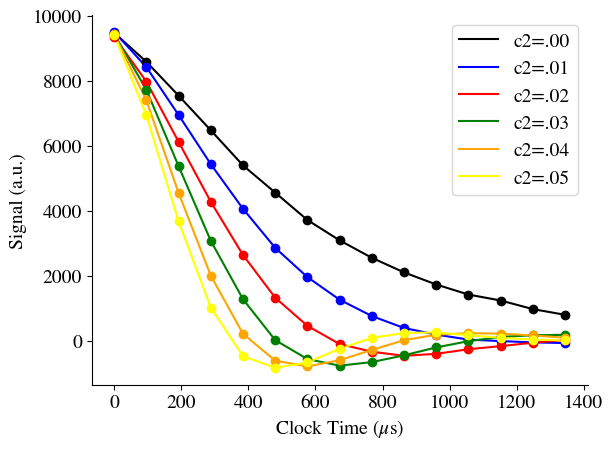

In [27]:
plt.plot(times, fids[(0.0, .0)], label="c2=.00", color="black")
plt.plot(times, fids[(0.0, .01)], label="c2=.01", color="blue")
plt.plot(times, fids[(0.0, .02)], label="c2=.02", color="red")
plt.plot(times, fids[(0.0, .03)], label="c2=.03", color="green")
plt.plot(times, fids[(0.0, .04)], label="c2=.04", color="orange")
plt.plot(times, fids[(0.0, .05)],  label="c2=.05", color="yellow")
plt.plot(times, fids[(0.0, .0)], 'o', color="black")
plt.plot(times, fids[(0.0, .01)], 'o', color="blue")
plt.plot(times, fids[(0.0, .02)], 'o', color="red")
plt.plot(times, fids[(0.0, .03)], 'o', color="green")
plt.plot(times, fids[(0.0, .04)], 'o', color="orange")
plt.plot(times, fids[(0.0, .05)], 'o', color="yellow")
plt.legend()
plt.xlabel(rf"Clock Time ($\mu$s)")
plt.ylabel(r"Signal (a.u.)")
plt.savefig("ken_fid_direct.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("ken_fid_direct.png", format="png", dpi=900, bbox_inches="tight")
plt.show()

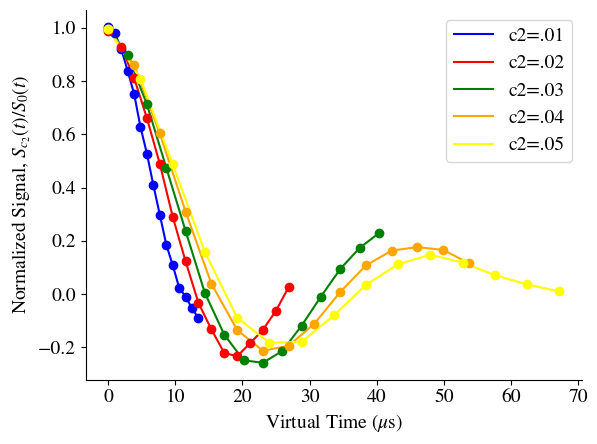

In [28]:
plt.plot(times*.01, fids[(0.0, .01)]/fids[(0.0, .0)], label="c2=.01", color="blue")
plt.plot(times*.02, fids[(0.0, .02)]/fids[(0.0, .0)], label="c2=.02", color="red")
plt.plot(times*.03, fids[(0.0, .03)]/fids[(0.0, .0)], label="c2=.03", color="green")
plt.plot(times*.04, fids[(0.0, .04)]/fids[(0.0, .0)], label="c2=.04", color ="orange")
plt.plot(times*.05, fids[(0.0, .05)]/fids[(0.0, .0)], label="c2=.05", color="yellow")
plt.plot(times*.01, fids[(0.0, .01)]/fids[(0.0, .0)], 'o', color="blue")
plt.plot(times*.02, fids[(0.0, .02)]/fids[(0.0, .0)], 'o', color="red")
plt.plot(times*.03, fids[(0.0, .03)]/fids[(0.0, .0)], 'o', color="green")
plt.plot(times*.04, fids[(0.0, .04)]/fids[(0.0, .0)], 'o', color="orange")
plt.plot(times*.05, fids[(0.0, .05)]/fids[(0.0, .0)], 'o', color="yellow")
plt.legend()
plt.xlabel(rf"Virtual Time ($\mu$s)")
plt.ylabel(r"Normalized Signal, $S_{c_2}(t)/S_0(t)$")
plt.savefig("ken_fid_rescale.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("ken_fid_rescale.png", format="png", dpi=900, bbox_inches="tight")
plt.show()

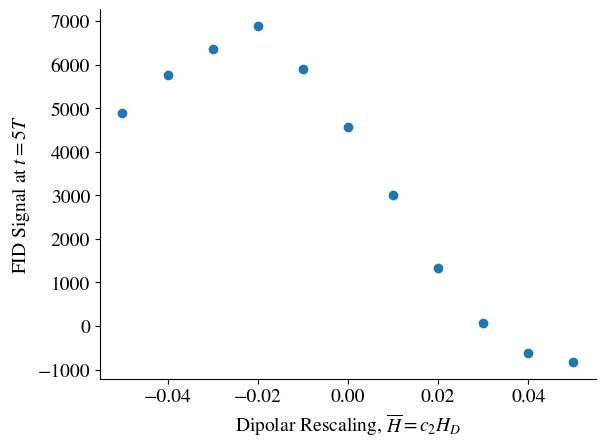

In [29]:
susp_test = get_tpc_data(f"susp_test.dat", 890, normalize=False,use_real=True)
x_axis = np.arange(-.05,.06,.01)
plt.scatter(x_axis,susp_test)
plt.xlabel(r"Dipolar Rescaling, $\overline{H} = c_2 H_D$")
plt.ylabel(r"FID Signal at $t=5T$")
plt.savefig("susp_test.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("susp_test.png", format="png", dpi=900, bbox_inches="tight")
plt.show()

In [30]:
fids[(0.0,-0.02)] = get_tpc_data(f"fid_m02.dat", 891, normalize=False,use_real=True)
fids[(0.0,-0.01)] = get_tpc_data(f"fid_m01.dat", 892, normalize=False,use_real=True)

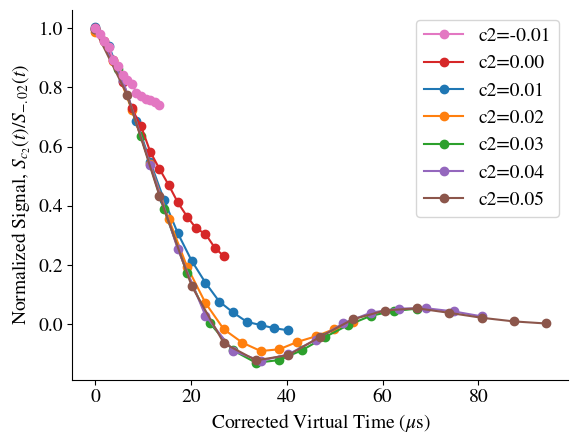

In [31]:
for key, sequence in fids.items():
    c1, c2 = key
    if c2 != -0.02:
        plt.plot(times*(c2+.02), sequence / fids[(0.0, -.02)], 'o-', label=f"c2={c2:.2f}")

handles, labels = plt.gca().get_legend_handles_labels()
sorted_labels_handles = sorted(zip(labels, handles), key=lambda x: float(x[0].split('=')[1]))
labels, handles = zip(*sorted_labels_handles)
plt.legend(handles, labels)

plt.xlabel(rf"Corrected Virtual Time ($\mu$s)")
plt.ylabel(r"Normalized Signal, $S_{c_2}(t)/S_{-.02}(t)$")
plt.savefig("ken_fid_rescale_neg.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("ken_fid_rescale_neg.png", format="png", dpi=900, bbox_inches="tight")
plt.show()

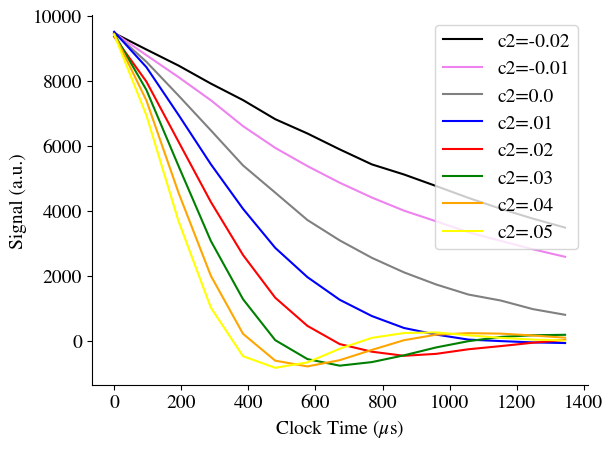

In [32]:
plt.errorbar(times, fids[(0.0, -.02)], label="c2=-0.02", color="black")
plt.errorbar(times, fids[(0.0, -.01)],label="c2=-0.01", color="violet")
plt.errorbar(times, fids[(0.0, .0)],  label="c2=0.0", color="grey")
plt.errorbar(times, fids[(0.0, .01)],  label="c2=.01", color="blue")
plt.errorbar(times, fids[(0.0, .02)], label="c2=.02", color="red")
plt.errorbar(times, fids[(0.0, .03)], label="c2=.03", color="green")
plt.errorbar(times, fids[(0.0, .04)],  label="c2=.04", color="orange")
plt.errorbar(times, fids[(0.0, .05)],  label="c2=.05", color="yellow")
plt.legend()
plt.xlabel(rf"Clock Time ($\mu$s)")
plt.ylabel(r"Signal (a.u.)")
plt.show()